In [1]:
from functools import partial
from itertools import combinations

from craterdetection.matching.database import CraterDatabase, load_craters, extract_robbins_dataset, crater_representation, CoplanarInvariants
from astropy.coordinates import spherical_to_cartesian, cartesian_to_spherical
from craterdetection.common.coordinates import ENU_system
from craterdetection.common.camera import *
import craterdetection.common.constants as const

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import networkx as nx
import sklearn.neighbors

In [2]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id_cat = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[4, 30])
)

In [3]:
R_moon = 1737.4
x_cat, y_cat, z_cat = map(np.array, spherical_to_cartesian(R_moon, lat_cat, long_cat))

adjacency_matrix = sklearn.neighbors.radius_neighbors_graph(np.array([x_cat, y_cat, z_cat]).T, 200,
                                                                  mode='connectivity',
                                                                  metric='euclidean', n_jobs=-1)

graph = nx.from_scipy_sparse_matrix(adjacency_matrix)
crater_triads = np.array([c for c in nx.cycle_basis(graph) if len(c) == 3])

In [83]:
p_M_ijk = np.moveaxis(
    np.concatenate(
        (x_cat[crater_triads].T[None, ...],
         y_cat[crater_triads].T[None, ...],
         z_cat[crater_triads].T[None, ...]),
        axis=0
    ),
    0, 2)[..., None]
p_centroid = np.mean(p_M_ijk, axis=0)

In [ ]:
# VIRTUAL CAMERA
alt = 300
p_vcam = p_centroid + (p_centroid/LA.norm(p_centroid, axis=1)[..., None])*alt

k = np.array([0., 0., 1.])[:, None]
Z_ax_cam = -(p_vcam / LA.norm(p_vcam, ord=2, axis=(1, 2))[:, None, None])

X_ax_cam = np.cross(k[None, ...], p_vcam, axis=1)
X_ax_cam /= LA.norm(X_ax_cam, ord=2, axis=(1, 2))[:, None, None]

Y_ax_cam = np.cross(Z_ax_cam, X_ax_cam, axis=1)
Y_ax_cam /= LA.norm(Y_ax_cam, ord=2, axis=(1, 2))[:, None, None]

T_CM = np.concatenate((X_ax_cam, Y_ax_cam, Z_ax_cam), axis=-1)
if (LA.matrix_rank(T_CM) != 3).any():
    raise Warning("Invalid camera attitude matrices present!:\n", T_CM)

In [ ]:
f_x = (const.CAMERA_RESOLUTION[0]/2) / np.tan(np.radians(const.CAMERA_FOV)/2)
f_y = (const.CAMERA_RESOLUTION[1]/2) / np.tan(np.radians(const.CAMERA_FOV)/2)

K = np.array([[f_x, 0,       const.CAMERA_RESOLUTION[0]/2],
             [0,    f_y,     const.CAMERA_RESOLUTION[1]/2],
             [0,    0,       1]])
T_MC = LA.inv(T_CM)
P_MC = K @ T_MC @ np.concatenate((np.tile(np.identity(3), (len(p_vcam), 1, 1)), -p_vcam), axis=2)

In [ ]:
T_EM_i = np.concatenate(ENU_system(p_M_ijk[0]), axis=-1)
T_EM_j = np.concatenate(ENU_system(p_M_ijk[1]), axis=-1)
T_EM_k = np.concatenate(ENU_system(p_M_ijk[2]), axis=-1)

S = np.concatenate((np.identity(2), np.zeros((1, 2))), axis=0)

H_M_i = np.concatenate((T_EM_i @ S, p_M_ijk[0]), axis=-1)
H_M_j = np.concatenate((T_EM_j @ S, p_M_ijk[1]), axis=-1)
H_M_k = np.concatenate((T_EM_k @ S, p_M_ijk[2]), axis=-1)

In [95]:
C_cat = crater_representation(major_cat, minor_cat, psi_cat)
C_i, C_j, C_k = (C_cat[vertex] for vertex in crater_triads.T)

In [97]:
H_C_i = P_MC @ np.concatenate((H_M_i, np.tile(k.T[None, ...], (len(H_M_i), 1, 1))), axis=1)
H_C_j = P_MC @ np.concatenate((H_M_j, np.tile(k.T[None, ...], (len(H_M_j), 1, 1))), axis=1)
H_C_k = P_MC @ np.concatenate((H_M_k, np.tile(k.T[None, ...], (len(H_M_k), 1, 1))), axis=1)

In [98]:
A_i = LA.inv(H_C_i).transpose((0, 2, 1)) @ C_i @ LA.inv(H_C_i)
A_j = LA.inv(H_C_j).transpose((0, 2, 1)) @ C_j @ LA.inv(H_C_j)
A_k = LA.inv(H_C_k).transpose((0, 2, 1)) @ C_k @ LA.inv(H_C_k)

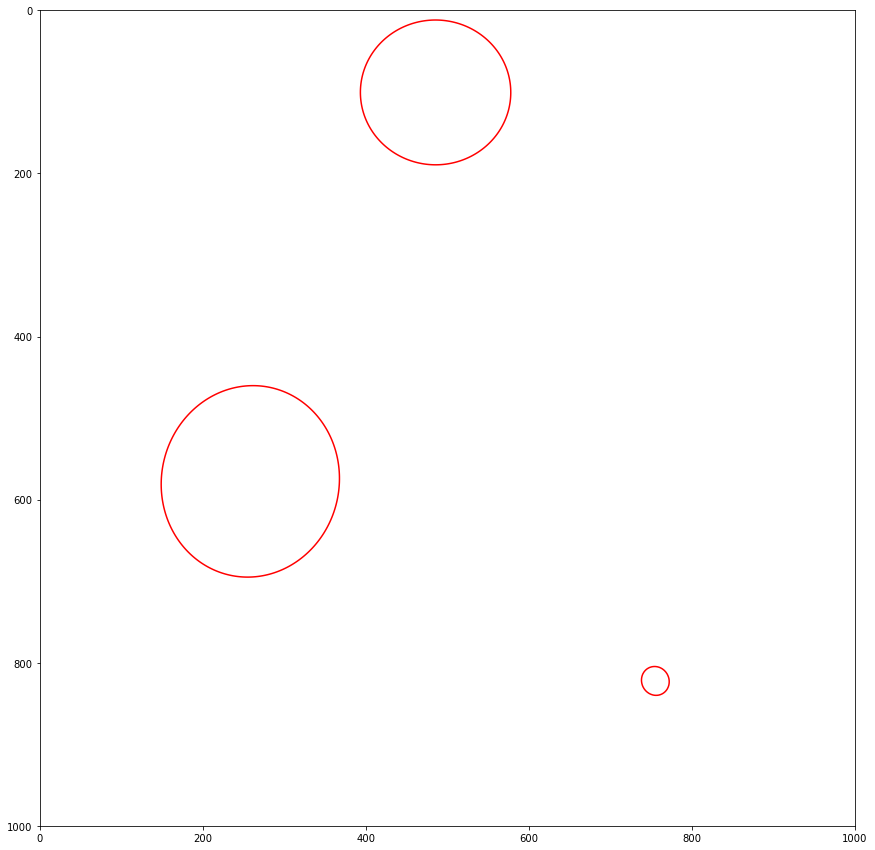

In [99]:
x_plot = np.linspace(0, const.CAMERA_RESOLUTION[0], 500)
y_plot = np.linspace(0, const.CAMERA_RESOLUTION[1], 500)
x_plot, y_plot = np.meshgrid(x_plot, y_plot)

xy_homogeneous = np.concatenate(
    (
        x_plot.ravel()[None, :],
        y_plot.ravel()[None, :],
        np.ones_like(x_plot.ravel()[None, :])
    ),
    axis=0
).T[..., None]

# c = xy_homogeneous.transpose(0, 2, 1) @ A_i[:, None, ...] @ xy_homogeneous
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'aspect': 'equal'})
# Set axes according to camera pixel space convention
ax.set_xlim(0, const.CAMERA_RESOLUTION[0])
ax.set_ylim(const.CAMERA_RESOLUTION[1], 0)
i = 1337
for a_i in [A_i[i], A_j[i], A_k[i]]:
    c = xy_homogeneous.transpose(0, 2, 1) @ a_i @ xy_homogeneous
    ax.contour(x_plot, y_plot, c.reshape(x_plot.shape), [0], colors='r')

In [100]:
CoplanarInvariants(crater_triads[i], A_i[i], A_j[i], A_k[i]).get_pattern()

array([[ -74.89466069, -299.21495371,  -22.83789522,  -24.34778725,
        -664.219257  , -197.96758292, -722.12691184]])